In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [2]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])

class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
    
    def set_stage(self, stage):
        self.stage = stage

In [3]:
from torch.utils.data import DataLoader
data = NCarsImageDataset("./Datasety/CIFAR10-DVS_128_exp", transform=transforms)

generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [4]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet50_CIFAR10-DVS_Hardtanh_ReLUmaxpool__128x128_FC2_128x128_pretrained_aug_corrected_exp1.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}'.format( correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [6]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes = 10, in_channels=6).to("cuda")
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kerne

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv

In [9]:
torch.autograd.set_detect_anomaly(True)
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=300,save_best=True, save_thr=48)

100%|██████████| 219/219 [00:54<00:00,  4.01it/s]


Epoch [1/300], Step [219/219], Loss: 3.1738, Accuracy: 0.1029
Accuracy of the network: 0.1 Loss: 2.8195718983386424


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [2/300], Step [219/219], Loss: 2.7483, Accuracy: 0.1000
Accuracy of the network: 0.09066666666666667 Loss: 2.483323221511029


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [3/300], Step [219/219], Loss: 2.6822, Accuracy: 0.1040
Accuracy of the network: 0.10533333333333333 Loss: 2.64460792693686


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [4/300], Step [219/219], Loss: 2.6464, Accuracy: 0.0970
Accuracy of the network: 0.095 Loss: 2.5589072019495864


100%|██████████| 219/219 [00:55<00:00,  3.98it/s]


Epoch [5/300], Step [219/219], Loss: 2.3481, Accuracy: 0.1386
Accuracy of the network: 0.14966666666666667 Loss: 2.203694617494624


100%|██████████| 219/219 [00:53<00:00,  4.09it/s]


Epoch [6/300], Step [219/219], Loss: 2.2159, Accuracy: 0.1493
Accuracy of the network: 0.15566666666666668 Loss: 2.1448558454817914


100%|██████████| 219/219 [00:53<00:00,  4.08it/s]


Epoch [7/300], Step [219/219], Loss: 2.1910, Accuracy: 0.1584
Accuracy of the network: 0.14733333333333334 Loss: 2.2430866576255637


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [8/300], Step [219/219], Loss: 2.1839, Accuracy: 0.1631
Accuracy of the network: 0.17266666666666666 Loss: 2.1144957073191377


100%|██████████| 219/219 [00:52<00:00,  4.14it/s]


Epoch [9/300], Step [219/219], Loss: 2.1882, Accuracy: 0.1620
Accuracy of the network: 0.14633333333333334 Loss: 2.194477531504124


100%|██████████| 219/219 [00:54<00:00,  3.99it/s]


Epoch [10/300], Step [219/219], Loss: 2.1552, Accuracy: 0.1731
Accuracy of the network: 0.16966666666666666 Loss: 2.1678301159371722


100%|██████████| 219/219 [00:53<00:00,  4.10it/s]


Epoch [11/300], Step [219/219], Loss: 2.1399, Accuracy: 0.1760
Accuracy of the network: 0.17366666666666666 Loss: 2.132593421225852


100%|██████████| 219/219 [00:54<00:00,  4.05it/s]


Epoch [12/300], Step [219/219], Loss: 2.1546, Accuracy: 0.1714
Accuracy of the network: 0.185 Loss: 2.130096638456304


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [13/300], Step [219/219], Loss: 2.1303, Accuracy: 0.1737
Accuracy of the network: 0.19866666666666666 Loss: 2.094496965408325


100%|██████████| 219/219 [00:53<00:00,  4.10it/s]


Epoch [14/300], Step [219/219], Loss: 2.1213, Accuracy: 0.1826
Accuracy of the network: 0.19933333333333333 Loss: 2.101958396586966


100%|██████████| 219/219 [00:53<00:00,  4.07it/s]


Epoch [15/300], Step [219/219], Loss: 2.1365, Accuracy: 0.1800
Accuracy of the network: 0.152 Loss: 2.1993671199108693


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [16/300], Step [219/219], Loss: 2.1428, Accuracy: 0.1731
Accuracy of the network: 0.16033333333333333 Loss: 2.180036118690004


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [17/300], Step [219/219], Loss: 2.1264, Accuracy: 0.1816
Accuracy of the network: 0.18666666666666668 Loss: 2.116359940234651


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [18/300], Step [219/219], Loss: 2.1141, Accuracy: 0.1810
Accuracy of the network: 0.18466666666666667 Loss: 2.1180584506785616


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [19/300], Step [219/219], Loss: 2.1299, Accuracy: 0.1800
Accuracy of the network: 0.17833333333333334 Loss: 2.101440191268921


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [20/300], Step [219/219], Loss: 2.1281, Accuracy: 0.1741
Accuracy of the network: 0.18766666666666668 Loss: 2.1272808605052056


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [21/300], Step [219/219], Loss: 2.1097, Accuracy: 0.1889
Accuracy of the network: 0.18766666666666668 Loss: 2.1246606593436383


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [22/300], Step [219/219], Loss: 2.1173, Accuracy: 0.1821
Accuracy of the network: 0.193 Loss: 2.185664818641987


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [23/300], Step [219/219], Loss: 2.0999, Accuracy: 0.1884
Accuracy of the network: 0.21 Loss: 2.1022653668484788


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [24/300], Step [219/219], Loss: 2.1154, Accuracy: 0.1800
Accuracy of the network: 0.15833333333333333 Loss: 2.1636693071811757


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [25/300], Step [219/219], Loss: 2.0990, Accuracy: 0.1817
Accuracy of the network: 0.19633333333333333 Loss: 2.106415496227589


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [26/300], Step [219/219], Loss: 2.1111, Accuracy: 0.1817
Accuracy of the network: 0.14933333333333335 Loss: 2.2561954602282097


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [27/300], Step [219/219], Loss: 2.0960, Accuracy: 0.1874
Accuracy of the network: 0.184 Loss: 2.1805200830419014


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [28/300], Step [219/219], Loss: 2.0984, Accuracy: 0.1937
Accuracy of the network: 0.21466666666666667 Loss: 2.0671217428877


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [29/300], Step [219/219], Loss: 2.0945, Accuracy: 0.1853
Accuracy of the network: 0.18766666666666668 Loss: 2.0748186821633197


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [30/300], Step [219/219], Loss: 2.0783, Accuracy: 0.2059
Accuracy of the network: 0.201 Loss: 2.0672911836745893


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [31/300], Step [219/219], Loss: 2.0458, Accuracy: 0.2227
Accuracy of the network: 0.22733333333333333 Loss: 2.0300408005714417


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [32/300], Step [219/219], Loss: 2.0327, Accuracy: 0.2306
Accuracy of the network: 0.25133333333333335 Loss: 2.0033156339158404


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [33/300], Step [219/219], Loss: 2.0197, Accuracy: 0.2313
Accuracy of the network: 0.209 Loss: 2.0457593291363816


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [34/300], Step [219/219], Loss: 1.9999, Accuracy: 0.2337
Accuracy of the network: 0.2693333333333333 Loss: 1.9553873272652322


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [35/300], Step [219/219], Loss: 1.9773, Accuracy: 0.2519
Accuracy of the network: 0.25833333333333336 Loss: 1.9471085134972916


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [36/300], Step [219/219], Loss: 1.9492, Accuracy: 0.2594
Accuracy of the network: 0.21766666666666667 Loss: 1.986285555869975


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [37/300], Step [219/219], Loss: 1.9276, Accuracy: 0.2670
Accuracy of the network: 0.2976666666666667 Loss: 1.8985839638304203


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [38/300], Step [219/219], Loss: 1.9167, Accuracy: 0.2693
Accuracy of the network: 0.273 Loss: 1.906057153610473


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [39/300], Step [219/219], Loss: 1.9056, Accuracy: 0.2826
Accuracy of the network: 0.2803333333333333 Loss: 1.9054955003109384


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [40/300], Step [219/219], Loss: 1.8852, Accuracy: 0.2877
Accuracy of the network: 0.27066666666666667 Loss: 1.9220070927701098


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [41/300], Step [219/219], Loss: 1.8889, Accuracy: 0.2891
Accuracy of the network: 0.284 Loss: 1.9306778007365288


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [42/300], Step [219/219], Loss: 1.8669, Accuracy: 0.2979
Accuracy of the network: 0.3016666666666667 Loss: 1.9052787245588099


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [43/300], Step [219/219], Loss: 1.8718, Accuracy: 0.2973
Accuracy of the network: 0.322 Loss: 1.8658476230945993


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [44/300], Step [219/219], Loss: 1.8448, Accuracy: 0.3113
Accuracy of the network: 0.31833333333333336 Loss: 1.8325454148840397


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [45/300], Step [219/219], Loss: 1.8339, Accuracy: 0.3207
Accuracy of the network: 0.311 Loss: 1.8586077005305188


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [46/300], Step [219/219], Loss: 1.8357, Accuracy: 0.3190
Accuracy of the network: 0.3303333333333333 Loss: 1.8281957367633253


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [47/300], Step [219/219], Loss: 1.8180, Accuracy: 0.3260
Accuracy of the network: 0.308 Loss: 1.9033617110962564


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [48/300], Step [219/219], Loss: 1.8046, Accuracy: 0.3319
Accuracy of the network: 0.31166666666666665 Loss: 1.837162582164115


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [49/300], Step [219/219], Loss: 1.7941, Accuracy: 0.3329
Accuracy of the network: 0.3526666666666667 Loss: 1.792513943733053


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [50/300], Step [219/219], Loss: 1.7775, Accuracy: 0.3443
Accuracy of the network: 0.341 Loss: 1.7751483080234933


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [51/300], Step [219/219], Loss: 1.7739, Accuracy: 0.3377
Accuracy of the network: 0.344 Loss: 1.7906876104943297


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [52/300], Step [219/219], Loss: 1.7616, Accuracy: 0.3481
Accuracy of the network: 0.325 Loss: 1.8214341503508547


100%|██████████| 219/219 [00:50<00:00,  4.29it/s]


Epoch [53/300], Step [219/219], Loss: 1.7454, Accuracy: 0.3554
Accuracy of the network: 0.344 Loss: 1.7570497317517058


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [54/300], Step [219/219], Loss: 1.7303, Accuracy: 0.3637
Accuracy of the network: 0.36333333333333334 Loss: 1.7515832490109382


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [55/300], Step [219/219], Loss: 1.7177, Accuracy: 0.3699
Accuracy of the network: 0.367 Loss: 1.7349565992964076


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [56/300], Step [219/219], Loss: 1.7179, Accuracy: 0.3663
Accuracy of the network: 0.36133333333333334 Loss: 1.736960567058401


100%|██████████| 219/219 [00:50<00:00,  4.29it/s]


Epoch [57/300], Step [219/219], Loss: 1.6966, Accuracy: 0.3779
Accuracy of the network: 0.374 Loss: 1.7022554329101076


100%|██████████| 219/219 [00:50<00:00,  4.29it/s]


Epoch [58/300], Step [219/219], Loss: 1.6897, Accuracy: 0.3834
Accuracy of the network: 0.39566666666666667 Loss: 1.6868013904449788


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [59/300], Step [219/219], Loss: 1.6912, Accuracy: 0.3807
Accuracy of the network: 0.38166666666666665 Loss: 1.6992289449306244


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [60/300], Step [219/219], Loss: 1.6762, Accuracy: 0.3836
Accuracy of the network: 0.36966666666666664 Loss: 1.715321936505906


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [61/300], Step [219/219], Loss: 1.6693, Accuracy: 0.3893
Accuracy of the network: 0.39566666666666667 Loss: 1.674399623211394


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [62/300], Step [219/219], Loss: 1.6662, Accuracy: 0.3896
Accuracy of the network: 0.36633333333333334 Loss: 1.6967918581150947


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [63/300], Step [219/219], Loss: 1.6677, Accuracy: 0.3874
Accuracy of the network: 0.38266666666666665 Loss: 1.6777641227904787


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [64/300], Step [219/219], Loss: 1.6580, Accuracy: 0.3900
Accuracy of the network: 0.384 Loss: 1.6679207035835752


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [65/300], Step [219/219], Loss: 1.6513, Accuracy: 0.3864
Accuracy of the network: 0.388 Loss: 1.6559714205721592


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [66/300], Step [219/219], Loss: 1.6377, Accuracy: 0.3989
Accuracy of the network: 0.37966666666666665 Loss: 1.677418904101595


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [67/300], Step [219/219], Loss: 1.6500, Accuracy: 0.3970
Accuracy of the network: 0.3963333333333333 Loss: 1.6451989120625434


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [68/300], Step [219/219], Loss: 1.6408, Accuracy: 0.4014
Accuracy of the network: 0.3923333333333333 Loss: 1.660262587222647


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [69/300], Step [219/219], Loss: 1.6234, Accuracy: 0.4044
Accuracy of the network: 0.398 Loss: 1.6242493289582274


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [70/300], Step [219/219], Loss: 1.6220, Accuracy: 0.4089
Accuracy of the network: 0.4043333333333333 Loss: 1.617755375009902


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [71/300], Step [219/219], Loss: 1.6099, Accuracy: 0.4129
Accuracy of the network: 0.39166666666666666 Loss: 1.6673876490998776


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [72/300], Step [219/219], Loss: 1.6036, Accuracy: 0.4133
Accuracy of the network: 0.4033333333333333 Loss: 1.6373962316107242


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [73/300], Step [219/219], Loss: 1.5820, Accuracy: 0.4170
Accuracy of the network: 0.4013333333333333 Loss: 1.627193696955417


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [74/300], Step [219/219], Loss: 1.5994, Accuracy: 0.4131
Accuracy of the network: 0.404 Loss: 1.5983231131066666


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [75/300], Step [219/219], Loss: 1.5897, Accuracy: 0.4216
Accuracy of the network: 0.4103333333333333 Loss: 1.6172131249245176


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [76/300], Step [219/219], Loss: 1.5823, Accuracy: 0.4240
Accuracy of the network: 0.408 Loss: 1.5988551454341158


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [77/300], Step [219/219], Loss: 1.5748, Accuracy: 0.4241
Accuracy of the network: 0.4026666666666667 Loss: 1.6236339148054733


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [78/300], Step [219/219], Loss: 1.5765, Accuracy: 0.4303
Accuracy of the network: 0.39766666666666667 Loss: 1.619517670032826


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [79/300], Step [219/219], Loss: 1.5440, Accuracy: 0.4349
Accuracy of the network: 0.411 Loss: 1.6189667481057188


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [80/300], Step [219/219], Loss: 1.5545, Accuracy: 0.4313
Accuracy of the network: 0.4206666666666667 Loss: 1.590367632977506


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [81/300], Step [219/219], Loss: 1.5521, Accuracy: 0.4349
Accuracy of the network: 0.4176666666666667 Loss: 1.5924547048325235


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [82/300], Step [219/219], Loss: 1.5416, Accuracy: 0.4429
Accuracy of the network: 0.4156666666666667 Loss: 1.5951535587615155


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [83/300], Step [219/219], Loss: 1.5348, Accuracy: 0.4437
Accuracy of the network: 0.4036666666666667 Loss: 1.6083695698291698


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [84/300], Step [219/219], Loss: 1.5291, Accuracy: 0.4424
Accuracy of the network: 0.41433333333333333 Loss: 1.587874285718228


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [85/300], Step [219/219], Loss: 1.5192, Accuracy: 0.4434
Accuracy of the network: 0.422 Loss: 1.5821905897018758


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [86/300], Step [219/219], Loss: 1.5216, Accuracy: 0.4436
Accuracy of the network: 0.42133333333333334 Loss: 1.5884443914636652


100%|██████████| 219/219 [00:53<00:00,  4.13it/s]


Epoch [87/300], Step [219/219], Loss: 1.5177, Accuracy: 0.4489
Accuracy of the network: 0.416 Loss: 1.5926462957199583


100%|██████████| 219/219 [00:53<00:00,  4.07it/s]


Epoch [88/300], Step [219/219], Loss: 1.5053, Accuracy: 0.4489
Accuracy of the network: 0.42933333333333334 Loss: 1.5845496692556016


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [89/300], Step [219/219], Loss: 1.4929, Accuracy: 0.4604
Accuracy of the network: 0.423 Loss: 1.5734306383640209


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [90/300], Step [219/219], Loss: 1.4765, Accuracy: 0.4589
Accuracy of the network: 0.43433333333333335 Loss: 1.5520918432702409


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [91/300], Step [219/219], Loss: 1.4901, Accuracy: 0.4643
Accuracy of the network: 0.42966666666666664 Loss: 1.5691663039491532


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [92/300], Step [219/219], Loss: 1.4849, Accuracy: 0.4591
Accuracy of the network: 0.447 Loss: 1.5647595296514796


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [93/300], Step [219/219], Loss: 1.4638, Accuracy: 0.4626
Accuracy of the network: 0.43533333333333335 Loss: 1.5570621515842193


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [94/300], Step [219/219], Loss: 1.4520, Accuracy: 0.4751
Accuracy of the network: 0.4493333333333333 Loss: 1.5148546036253585


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [95/300], Step [219/219], Loss: 1.4602, Accuracy: 0.4734
Accuracy of the network: 0.438 Loss: 1.54537085649815


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [96/300], Step [219/219], Loss: 1.4460, Accuracy: 0.4800
Accuracy of the network: 0.44433333333333336 Loss: 1.5239325723749526


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [97/300], Step [219/219], Loss: 1.4328, Accuracy: 0.4780
Accuracy of the network: 0.44366666666666665 Loss: 1.5336720043040337


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [98/300], Step [219/219], Loss: 1.4385, Accuracy: 0.4741
Accuracy of the network: 0.46266666666666667 Loss: 1.5010220700121941


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [99/300], Step [219/219], Loss: 1.4270, Accuracy: 0.4866
Accuracy of the network: 0.46366666666666667 Loss: 1.4954625241299893


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [100/300], Step [219/219], Loss: 1.4206, Accuracy: 0.4893
Accuracy of the network: 0.45 Loss: 1.5167937925521364


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [101/300], Step [219/219], Loss: 1.4195, Accuracy: 0.4850
Accuracy of the network: 0.4613333333333333 Loss: 1.4864200949668884


100%|██████████| 219/219 [00:52<00:00,  4.13it/s]


Epoch [102/300], Step [219/219], Loss: 1.4081, Accuracy: 0.4961
Accuracy of the network: 0.46066666666666667 Loss: 1.4965940802655322


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [103/300], Step [219/219], Loss: 1.4194, Accuracy: 0.4883
Accuracy of the network: 0.469 Loss: 1.464521678204232


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [104/300], Step [219/219], Loss: 1.4014, Accuracy: 0.4989
Accuracy of the network: 0.456 Loss: 1.5013758121652807


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [105/300], Step [219/219], Loss: 1.3915, Accuracy: 0.5023
Accuracy of the network: 0.4676666666666667 Loss: 1.4806200227838882


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [106/300], Step [219/219], Loss: 1.3942, Accuracy: 0.5000
Accuracy of the network: 0.4623333333333333 Loss: 1.4753519968783602


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [107/300], Step [219/219], Loss: 1.3946, Accuracy: 0.4944
Accuracy of the network: 0.4713333333333333 Loss: 1.4669819271310847


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [108/300], Step [219/219], Loss: 1.3848, Accuracy: 0.4999
Accuracy of the network: 0.467 Loss: 1.4691467310519928


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [109/300], Step [219/219], Loss: 1.3784, Accuracy: 0.5040
Accuracy of the network: 0.462 Loss: 1.474740408836527


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [110/300], Step [219/219], Loss: 1.3717, Accuracy: 0.5130
Accuracy of the network: 0.4706666666666667 Loss: 1.4647985715815361


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [111/300], Step [219/219], Loss: 1.3710, Accuracy: 0.5099
Accuracy of the network: 0.4703333333333333 Loss: 1.4676138822068558


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [112/300], Step [219/219], Loss: 1.3585, Accuracy: 0.5114
Accuracy of the network: 0.4756666666666667 Loss: 1.4759029023190762


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [113/300], Step [219/219], Loss: 1.3509, Accuracy: 0.5139
Accuracy of the network: 0.4643333333333333 Loss: 1.4595034807286364


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [114/300], Step [219/219], Loss: 1.3478, Accuracy: 0.5139
Accuracy of the network: 0.473 Loss: 1.452043500352413


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [115/300], Step [219/219], Loss: 1.3488, Accuracy: 0.5209
Accuracy of the network: 0.48 Loss: 1.451934299570449


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [116/300], Step [219/219], Loss: 1.3452, Accuracy: 0.5186
Accuracy of the network: 0.47433333333333333 Loss: 1.445486716133483


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [117/300], Step [219/219], Loss: 1.3403, Accuracy: 0.5181
Accuracy of the network: 0.4756666666666667 Loss: 1.4369688313058082


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [118/300], Step [219/219], Loss: 1.3341, Accuracy: 0.5273
Accuracy of the network: 0.485 Loss: 1.4453035954465256


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [119/300], Step [219/219], Loss: 1.3506, Accuracy: 0.5124
Accuracy of the network: 0.48833333333333334 Loss: 1.4379062918906516


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [120/300], Step [219/219], Loss: 1.3295, Accuracy: 0.5304
Accuracy of the network: 0.4866666666666667 Loss: 1.4204354387648561


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [121/300], Step [219/219], Loss: 1.3329, Accuracy: 0.5217
Accuracy of the network: 0.49 Loss: 1.4151530088262354


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [122/300], Step [219/219], Loss: 1.3152, Accuracy: 0.5260
Accuracy of the network: 0.4836666666666667 Loss: 1.4194873926487375


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [123/300], Step [219/219], Loss: 1.3107, Accuracy: 0.5347
Accuracy of the network: 0.491 Loss: 1.4317179170060665


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [124/300], Step [219/219], Loss: 1.3131, Accuracy: 0.5293
Accuracy of the network: 0.48533333333333334 Loss: 1.4363182237807741


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [125/300], Step [219/219], Loss: 1.3050, Accuracy: 0.5369
Accuracy of the network: 0.49166666666666664 Loss: 1.4265207153685548


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [126/300], Step [219/219], Loss: 1.3024, Accuracy: 0.5347
Accuracy of the network: 0.48966666666666664 Loss: 1.4224192855205942


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [127/300], Step [219/219], Loss: 1.3013, Accuracy: 0.5334
Accuracy of the network: 0.4886666666666667 Loss: 1.4227518464656586


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [128/300], Step [219/219], Loss: 1.2950, Accuracy: 0.5426
Accuracy of the network: 0.4876666666666667 Loss: 1.434691051219372


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [129/300], Step [219/219], Loss: 1.2880, Accuracy: 0.5420
Accuracy of the network: 0.4886666666666667 Loss: 1.40555931659455


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [130/300], Step [219/219], Loss: 1.2900, Accuracy: 0.5379
Accuracy of the network: 0.498 Loss: 1.4178819187144016


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [131/300], Step [219/219], Loss: 1.2833, Accuracy: 0.5427
Accuracy of the network: 0.49266666666666664 Loss: 1.4220140424180538


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [132/300], Step [219/219], Loss: 1.2799, Accuracy: 0.5426
Accuracy of the network: 0.4876666666666667 Loss: 1.421476090842105


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [133/300], Step [219/219], Loss: 1.2730, Accuracy: 0.5519
Accuracy of the network: 0.4866666666666667 Loss: 1.4266714922925259


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [134/300], Step [219/219], Loss: 1.2712, Accuracy: 0.5461
Accuracy of the network: 0.49366666666666664 Loss: 1.4034285088802905


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [135/300], Step [219/219], Loss: 1.2580, Accuracy: 0.5569
Accuracy of the network: 0.5023333333333333 Loss: 1.3913268802013803


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [136/300], Step [219/219], Loss: 1.2612, Accuracy: 0.5509
Accuracy of the network: 0.498 Loss: 1.4065430893542918


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [137/300], Step [219/219], Loss: 1.2603, Accuracy: 0.5523
Accuracy of the network: 0.5033333333333333 Loss: 1.3965525950523132


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [138/300], Step [219/219], Loss: 1.2430, Accuracy: 0.5606
Accuracy of the network: 0.49433333333333335 Loss: 1.3910663013762616


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [139/300], Step [219/219], Loss: 1.2454, Accuracy: 0.5514
Accuracy of the network: 0.497 Loss: 1.3916039149811927


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [140/300], Step [219/219], Loss: 1.2559, Accuracy: 0.5533
Accuracy of the network: 0.5066666666666667 Loss: 1.3766374397785106


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [141/300], Step [219/219], Loss: 1.2363, Accuracy: 0.5629
Accuracy of the network: 0.49866666666666665 Loss: 1.3908082830145003


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [142/300], Step [219/219], Loss: 1.2473, Accuracy: 0.5596
Accuracy of the network: 0.49533333333333335 Loss: 1.3862241899713557


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [143/300], Step [219/219], Loss: 1.2411, Accuracy: 0.5646
Accuracy of the network: 0.49733333333333335 Loss: 1.384982519961418


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [144/300], Step [219/219], Loss: 1.2303, Accuracy: 0.5590
Accuracy of the network: 0.49433333333333335 Loss: 1.412349612154859


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [145/300], Step [219/219], Loss: 1.2276, Accuracy: 0.5626
Accuracy of the network: 0.49766666666666665 Loss: 1.3871277678520122


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [146/300], Step [219/219], Loss: 1.2228, Accuracy: 0.5709
Accuracy of the network: 0.5043333333333333 Loss: 1.3911888612077592


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [147/300], Step [219/219], Loss: 1.2230, Accuracy: 0.5629
Accuracy of the network: 0.494 Loss: 1.3942287278936265


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [148/300], Step [219/219], Loss: 1.2199, Accuracy: 0.5686
Accuracy of the network: 0.49833333333333335 Loss: 1.383787528631535


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [149/300], Step [219/219], Loss: 1.2140, Accuracy: 0.5721
Accuracy of the network: 0.49933333333333335 Loss: 1.387050116949893


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [150/300], Step [219/219], Loss: 1.2135, Accuracy: 0.5673
Accuracy of the network: 0.49733333333333335 Loss: 1.3818303714407252


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [151/300], Step [219/219], Loss: 1.2069, Accuracy: 0.5664
Accuracy of the network: 0.5026666666666667 Loss: 1.3784883529581922


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [152/300], Step [219/219], Loss: 1.2132, Accuracy: 0.5664
Accuracy of the network: 0.5076666666666667 Loss: 1.3752204737764724


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [153/300], Step [219/219], Loss: 1.2082, Accuracy: 0.5659
Accuracy of the network: 0.508 Loss: 1.3747064579040447


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [154/300], Step [219/219], Loss: 1.2036, Accuracy: 0.5736
Accuracy of the network: 0.5146666666666667 Loss: 1.3527987409145275


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [155/300], Step [219/219], Loss: 1.2055, Accuracy: 0.5749
Accuracy of the network: 0.5083333333333333 Loss: 1.3777837385522558


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [156/300], Step [219/219], Loss: 1.1907, Accuracy: 0.5783
Accuracy of the network: 0.5116666666666667 Loss: 1.3519194785584794


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [157/300], Step [219/219], Loss: 1.1901, Accuracy: 0.5756
Accuracy of the network: 0.5163333333333333 Loss: 1.3641701118743166


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [158/300], Step [219/219], Loss: 1.1873, Accuracy: 0.5804
Accuracy of the network: 0.5136666666666667 Loss: 1.363165409006971


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [159/300], Step [219/219], Loss: 1.1839, Accuracy: 0.5793
Accuracy of the network: 0.515 Loss: 1.3602954776997263


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [160/300], Step [219/219], Loss: 1.1814, Accuracy: 0.5806
Accuracy of the network: 0.5153333333333333 Loss: 1.3484209332060306


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [161/300], Step [219/219], Loss: 1.1844, Accuracy: 0.5794
Accuracy of the network: 0.5116666666666667 Loss: 1.35224087377812


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [162/300], Step [219/219], Loss: 1.1876, Accuracy: 0.5837
Accuracy of the network: 0.5136666666666667 Loss: 1.3621469526848895


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [163/300], Step [219/219], Loss: 1.1761, Accuracy: 0.5837
Accuracy of the network: 0.5166666666666667 Loss: 1.3510860344196887


100%|██████████| 219/219 [00:52<00:00,  4.13it/s]


Epoch [164/300], Step [219/219], Loss: 1.1690, Accuracy: 0.5926
Accuracy of the network: 0.515 Loss: 1.3615301815753287


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [165/300], Step [219/219], Loss: 1.1783, Accuracy: 0.5826
Accuracy of the network: 0.519 Loss: 1.351832594009156


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [166/300], Step [219/219], Loss: 1.1714, Accuracy: 0.5831
Accuracy of the network: 0.5153333333333333 Loss: 1.3571808522051954


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [167/300], Step [219/219], Loss: 1.1637, Accuracy: 0.5906
Accuracy of the network: 0.5233333333333333 Loss: 1.3438098291133314


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [168/300], Step [219/219], Loss: 1.1653, Accuracy: 0.5860
Accuracy of the network: 0.5236666666666666 Loss: 1.3417173211878919


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [169/300], Step [219/219], Loss: 1.1693, Accuracy: 0.5883
Accuracy of the network: 0.526 Loss: 1.3442867930899276


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [170/300], Step [219/219], Loss: 1.1516, Accuracy: 0.5979
Accuracy of the network: 0.524 Loss: 1.345888761763877


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [171/300], Step [219/219], Loss: 1.1594, Accuracy: 0.5907
Accuracy of the network: 0.52 Loss: 1.3443260053370862


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [172/300], Step [219/219], Loss: 1.1552, Accuracy: 0.5917
Accuracy of the network: 0.52 Loss: 1.3487633726698287


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [173/300], Step [219/219], Loss: 1.1561, Accuracy: 0.5837
Accuracy of the network: 0.524 Loss: 1.3429415219641747


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [174/300], Step [219/219], Loss: 1.1454, Accuracy: 0.5951
Accuracy of the network: 0.5243333333333333 Loss: 1.3367024013336668


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [175/300], Step [219/219], Loss: 1.1441, Accuracy: 0.5966
Accuracy of the network: 0.5266666666666666 Loss: 1.3403977903913944


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [176/300], Step [219/219], Loss: 1.1469, Accuracy: 0.5949
Accuracy of the network: 0.5243333333333333 Loss: 1.3311896666567375


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [177/300], Step [219/219], Loss: 1.1522, Accuracy: 0.5937
Accuracy of the network: 0.5213333333333333 Loss: 1.3429828863194648


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [178/300], Step [219/219], Loss: 1.1368, Accuracy: 0.5969
Accuracy of the network: 0.5236666666666666 Loss: 1.3389875806392508


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [179/300], Step [219/219], Loss: 1.1366, Accuracy: 0.6033
Accuracy of the network: 0.524 Loss: 1.3459928644464372


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [180/300], Step [219/219], Loss: 1.1409, Accuracy: 0.5984
Accuracy of the network: 0.5246666666666666 Loss: 1.352625661073847


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [181/300], Step [219/219], Loss: 1.1309, Accuracy: 0.6001
Accuracy of the network: 0.529 Loss: 1.3354706491561645


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [182/300], Step [219/219], Loss: 1.1329, Accuracy: 0.6030
Accuracy of the network: 0.522 Loss: 1.3354487159150712


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [183/300], Step [219/219], Loss: 1.1377, Accuracy: 0.5996
Accuracy of the network: 0.526 Loss: 1.3336394473593285


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [184/300], Step [219/219], Loss: 1.1207, Accuracy: 0.6010
Accuracy of the network: 0.5256666666666666 Loss: 1.33607975726432


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [185/300], Step [219/219], Loss: 1.1348, Accuracy: 0.5999
Accuracy of the network: 0.5333333333333333 Loss: 1.3259747161510143


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [186/300], Step [219/219], Loss: 1.1207, Accuracy: 0.6071
Accuracy of the network: 0.518 Loss: 1.3399650917408314


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [187/300], Step [219/219], Loss: 1.1116, Accuracy: 0.6131
Accuracy of the network: 0.53 Loss: 1.3300148565718468


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [188/300], Step [219/219], Loss: 1.1122, Accuracy: 0.6086
Accuracy of the network: 0.5306666666666666 Loss: 1.3356344915450888


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [189/300], Step [219/219], Loss: 1.1249, Accuracy: 0.6087
Accuracy of the network: 0.5306666666666666 Loss: 1.3206881715896281


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [190/300], Step [219/219], Loss: 1.1225, Accuracy: 0.6059
Accuracy of the network: 0.5263333333333333 Loss: 1.32597486960127


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [191/300], Step [219/219], Loss: 1.1138, Accuracy: 0.6057
Accuracy of the network: 0.5326666666666666 Loss: 1.3173510660516454


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [192/300], Step [219/219], Loss: 1.1161, Accuracy: 0.6073
Accuracy of the network: 0.527 Loss: 1.3347325046011742


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [193/300], Step [219/219], Loss: 1.1172, Accuracy: 0.6091
Accuracy of the network: 0.529 Loss: 1.323442263172028


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [194/300], Step [219/219], Loss: 1.1162, Accuracy: 0.6123
Accuracy of the network: 0.535 Loss: 1.3280978557911325


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [195/300], Step [219/219], Loss: 1.1094, Accuracy: 0.6104
Accuracy of the network: 0.5276666666666666 Loss: 1.3252925441620198


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [196/300], Step [219/219], Loss: 1.1168, Accuracy: 0.6077
Accuracy of the network: 0.5333333333333333 Loss: 1.3250045687594312


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [197/300], Step [219/219], Loss: 1.1244, Accuracy: 0.5996
Accuracy of the network: 0.527 Loss: 1.3320798588559983


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [198/300], Step [219/219], Loss: 1.1103, Accuracy: 0.6059
Accuracy of the network: 0.5253333333333333 Loss: 1.3281049924962065


100%|██████████| 219/219 [00:53<00:00,  4.08it/s]


Epoch [199/300], Step [219/219], Loss: 1.1011, Accuracy: 0.6110
Accuracy of the network: 0.5296666666666666 Loss: 1.325869638869103


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [200/300], Step [219/219], Loss: 1.1110, Accuracy: 0.6091
Accuracy of the network: 0.526 Loss: 1.3270815553817343


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [201/300], Step [219/219], Loss: 1.1114, Accuracy: 0.6097
Accuracy of the network: 0.5253333333333333 Loss: 1.3243489106918902


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [202/300], Step [219/219], Loss: 1.1124, Accuracy: 0.6060
Accuracy of the network: 0.528 Loss: 1.3324938124798713


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [203/300], Step [219/219], Loss: 1.0990, Accuracy: 0.6186
Accuracy of the network: 0.5313333333333333 Loss: 1.3210840288628922


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [204/300], Step [219/219], Loss: 1.1117, Accuracy: 0.6060
Accuracy of the network: 0.534 Loss: 1.3224655770240945


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [205/300], Step [219/219], Loss: 1.0995, Accuracy: 0.6124
Accuracy of the network: 0.5346666666666666 Loss: 1.323165348235597


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [206/300], Step [219/219], Loss: 1.0985, Accuracy: 0.6214
Accuracy of the network: 0.528 Loss: 1.3251543970818216


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [207/300], Step [219/219], Loss: 1.1019, Accuracy: 0.6119
Accuracy of the network: 0.5393333333333333 Loss: 1.3198893355562331


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [208/300], Step [219/219], Loss: 1.0967, Accuracy: 0.6134
Accuracy of the network: 0.528 Loss: 1.3279167331279593


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [209/300], Step [219/219], Loss: 1.0976, Accuracy: 0.6154
Accuracy of the network: 0.531 Loss: 1.3187911066603153


100%|██████████| 219/219 [00:50<00:00,  4.29it/s]


Epoch [210/300], Step [219/219], Loss: 1.0941, Accuracy: 0.6123
Accuracy of the network: 0.5246666666666666 Loss: 1.329725275648401


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [211/300], Step [219/219], Loss: 1.0919, Accuracy: 0.6153
Accuracy of the network: 0.538 Loss: 1.3135693060590865


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [212/300], Step [219/219], Loss: 1.0816, Accuracy: 0.6234
Accuracy of the network: 0.5306666666666666 Loss: 1.3146253919347803


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [213/300], Step [219/219], Loss: 1.0890, Accuracy: 0.6187
Accuracy of the network: 0.533 Loss: 1.3205604965382434


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [214/300], Step [219/219], Loss: 1.0958, Accuracy: 0.6103
Accuracy of the network: 0.543 Loss: 1.306216335042994


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [215/300], Step [219/219], Loss: 1.0925, Accuracy: 0.6163
Accuracy of the network: 0.5323333333333333 Loss: 1.3138185517585024


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [216/300], Step [219/219], Loss: 1.0914, Accuracy: 0.6170
Accuracy of the network: 0.5356666666666666 Loss: 1.3215408845150725


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [217/300], Step [219/219], Loss: 1.0931, Accuracy: 0.6197
Accuracy of the network: 0.5296666666666666 Loss: 1.3248036896928828


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [218/300], Step [219/219], Loss: 1.0913, Accuracy: 0.6166
Accuracy of the network: 0.5433333333333333 Loss: 1.3173372808923112


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [219/300], Step [219/219], Loss: 1.0920, Accuracy: 0.6170
Accuracy of the network: 0.541 Loss: 1.3144031522121835


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [220/300], Step [219/219], Loss: 1.0890, Accuracy: 0.6173
Accuracy of the network: 0.5343333333333333 Loss: 1.3094959043441934


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [221/300], Step [219/219], Loss: 1.0913, Accuracy: 0.6173
Accuracy of the network: 0.5326666666666666 Loss: 1.3174651461712859


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [222/300], Step [219/219], Loss: 1.0965, Accuracy: 0.6159
Accuracy of the network: 0.5366666666666666 Loss: 1.316198762426985


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [223/300], Step [219/219], Loss: 1.0833, Accuracy: 0.6143
Accuracy of the network: 0.5296666666666666 Loss: 1.3128423380090835


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [224/300], Step [219/219], Loss: 1.0675, Accuracy: 0.6219
Accuracy of the network: 0.5296666666666666 Loss: 1.3170915417214657


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [225/300], Step [219/219], Loss: 1.0835, Accuracy: 0.6146
Accuracy of the network: 0.5386666666666666 Loss: 1.316003199587477


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [226/300], Step [219/219], Loss: 1.0737, Accuracy: 0.6191
Accuracy of the network: 0.5316666666666666 Loss: 1.3208287060260773


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [227/300], Step [219/219], Loss: 1.0947, Accuracy: 0.6141
Accuracy of the network: 0.5356666666666666 Loss: 1.310347080230713


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [228/300], Step [219/219], Loss: 1.0768, Accuracy: 0.6271
Accuracy of the network: 0.535 Loss: 1.309525598870947


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [229/300], Step [219/219], Loss: 1.0884, Accuracy: 0.6199
Accuracy of the network: 0.5303333333333333 Loss: 1.3156870108969667


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [230/300], Step [219/219], Loss: 1.0708, Accuracy: 0.6230
Accuracy of the network: 0.5316666666666666 Loss: 1.3188950977426894


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [231/300], Step [219/219], Loss: 1.0855, Accuracy: 0.6224
Accuracy of the network: 0.5436666666666666 Loss: 1.3049051818695474


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [232/300], Step [219/219], Loss: 1.0767, Accuracy: 0.6227
Accuracy of the network: 0.534 Loss: 1.3106565906646404


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [233/300], Step [219/219], Loss: 1.0798, Accuracy: 0.6199
Accuracy of the network: 0.536 Loss: 1.3099999586318403


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [234/300], Step [219/219], Loss: 1.0846, Accuracy: 0.6213
Accuracy of the network: 0.5376666666666666 Loss: 1.3050223696739116


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [235/300], Step [219/219], Loss: 1.0796, Accuracy: 0.6171
Accuracy of the network: 0.5413333333333333 Loss: 1.3064715386705195


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [236/300], Step [219/219], Loss: 1.0807, Accuracy: 0.6170
Accuracy of the network: 0.537 Loss: 1.3057149414052354


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [237/300], Step [219/219], Loss: 1.0720, Accuracy: 0.6221
Accuracy of the network: 0.5433333333333333 Loss: 1.3016142325198397


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [238/300], Step [219/219], Loss: 1.0786, Accuracy: 0.6246
Accuracy of the network: 0.54 Loss: 1.3078208584734734


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [239/300], Step [219/219], Loss: 1.0748, Accuracy: 0.6190
Accuracy of the network: 0.5353333333333333 Loss: 1.3136999905109406


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [240/300], Step [219/219], Loss: 1.0776, Accuracy: 0.6206
Accuracy of the network: 0.5426666666666666 Loss: 1.3065822035708325


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [241/300], Step [219/219], Loss: 1.0699, Accuracy: 0.6289
Accuracy of the network: 0.5303333333333333 Loss: 1.3180284924963688


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [242/300], Step [219/219], Loss: 1.0752, Accuracy: 0.6246
Accuracy of the network: 0.5376666666666666 Loss: 1.3044107461229284


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [243/300], Step [219/219], Loss: 1.0792, Accuracy: 0.6219
Accuracy of the network: 0.5376666666666666 Loss: 1.3116990448312555


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [244/300], Step [219/219], Loss: 1.0711, Accuracy: 0.6210
Accuracy of the network: 0.5356666666666666 Loss: 1.3086319996955547


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [245/300], Step [219/219], Loss: 1.0819, Accuracy: 0.6241
Accuracy of the network: 0.5373333333333333 Loss: 1.3062245890181114


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [246/300], Step [219/219], Loss: 1.0618, Accuracy: 0.6303
Accuracy of the network: 0.5326666666666666 Loss: 1.304090565823494


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [247/300], Step [219/219], Loss: 1.0659, Accuracy: 0.6277
Accuracy of the network: 0.5403333333333333 Loss: 1.3035851970632026


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [248/300], Step [219/219], Loss: 1.0654, Accuracy: 0.6243
Accuracy of the network: 0.5426666666666666 Loss: 1.3103651334630682


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [249/300], Step [219/219], Loss: 1.0726, Accuracy: 0.6281
Accuracy of the network: 0.5386666666666666 Loss: 1.2982585924736998


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [250/300], Step [219/219], Loss: 1.0642, Accuracy: 0.6273
Accuracy of the network: 0.536 Loss: 1.302922324297276


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [251/300], Step [219/219], Loss: 1.0723, Accuracy: 0.6237
Accuracy of the network: 0.5346666666666666 Loss: 1.3080088825936014


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [252/300], Step [219/219], Loss: 1.0643, Accuracy: 0.6244
Accuracy of the network: 0.5406666666666666 Loss: 1.305237037704346


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [253/300], Step [219/219], Loss: 1.0599, Accuracy: 0.6281
Accuracy of the network: 0.539 Loss: 1.3088901683371117


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [254/300], Step [219/219], Loss: 1.0681, Accuracy: 0.6250
Accuracy of the network: 0.5403333333333333 Loss: 1.3059902381389699


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [255/300], Step [219/219], Loss: 1.0668, Accuracy: 0.6284
Accuracy of the network: 0.5383333333333333 Loss: 1.3000909426110856


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [256/300], Step [219/219], Loss: 1.0667, Accuracy: 0.6266
Accuracy of the network: 0.5383333333333333 Loss: 1.3119207347961181


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [257/300], Step [219/219], Loss: 1.0557, Accuracy: 0.6324
Accuracy of the network: 0.5456666666666666 Loss: 1.3016947146425857


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [258/300], Step [219/219], Loss: 1.0617, Accuracy: 0.6286
Accuracy of the network: 0.539 Loss: 1.295951339792698


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [259/300], Step [219/219], Loss: 1.0683, Accuracy: 0.6227
Accuracy of the network: 0.544 Loss: 1.3078260364684653


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [260/300], Step [219/219], Loss: 1.0670, Accuracy: 0.6247
Accuracy of the network: 0.5393333333333333 Loss: 1.3050311676999355


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [261/300], Step [219/219], Loss: 1.0692, Accuracy: 0.6234
Accuracy of the network: 0.5386666666666666 Loss: 1.2977292182597708


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [262/300], Step [219/219], Loss: 1.0750, Accuracy: 0.6223
Accuracy of the network: 0.54 Loss: 1.2997788362046505


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [263/300], Step [219/219], Loss: 1.0751, Accuracy: 0.6209
Accuracy of the network: 0.5323333333333333 Loss: 1.3007156607952524


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [264/300], Step [219/219], Loss: 1.0578, Accuracy: 0.6313
Accuracy of the network: 0.544 Loss: 1.2952706059242816


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [265/300], Step [219/219], Loss: 1.0671, Accuracy: 0.6334
Accuracy of the network: 0.542 Loss: 1.2943267283287454


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [266/300], Step [219/219], Loss: 1.0589, Accuracy: 0.6309
Accuracy of the network: 0.536 Loss: 1.2924503982067108


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [267/300], Step [219/219], Loss: 1.0711, Accuracy: 0.6267
Accuracy of the network: 0.534 Loss: 1.2969913844098435


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [268/300], Step [219/219], Loss: 1.0719, Accuracy: 0.6249
Accuracy of the network: 0.5346666666666666 Loss: 1.2996757645556267


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [269/300], Step [219/219], Loss: 1.0606, Accuracy: 0.6270
Accuracy of the network: 0.5446666666666666 Loss: 1.2969508164740624


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [270/300], Step [219/219], Loss: 1.0686, Accuracy: 0.6330
Accuracy of the network: 0.536 Loss: 1.3081768231188997


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [271/300], Step [219/219], Loss: 1.0608, Accuracy: 0.6277
Accuracy of the network: 0.5396666666666666 Loss: 1.3108601202356054


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [272/300], Step [219/219], Loss: 1.0685, Accuracy: 0.6230
Accuracy of the network: 0.543 Loss: 1.2943945508053962


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [273/300], Step [219/219], Loss: 1.0483, Accuracy: 0.6339
Accuracy of the network: 0.539 Loss: 1.3055873963427036


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [274/300], Step [219/219], Loss: 1.0619, Accuracy: 0.6283
Accuracy of the network: 0.538 Loss: 1.299739217504542


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [275/300], Step [219/219], Loss: 1.0577, Accuracy: 0.6317
Accuracy of the network: 0.545 Loss: 1.2977213517148445


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [276/300], Step [219/219], Loss: 1.0687, Accuracy: 0.6196
Accuracy of the network: 0.5426666666666666 Loss: 1.2945788382215704


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [277/300], Step [219/219], Loss: 1.0643, Accuracy: 0.6304
Accuracy of the network: 0.5443333333333333 Loss: 1.289762923692135


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [278/300], Step [219/219], Loss: 1.0631, Accuracy: 0.6236
Accuracy of the network: 0.5416666666666666 Loss: 1.2970145839325926


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [279/300], Step [219/219], Loss: 1.0585, Accuracy: 0.6314
Accuracy of the network: 0.542 Loss: 1.3019634605722223


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [280/300], Step [219/219], Loss: 1.0614, Accuracy: 0.6314
Accuracy of the network: 0.536 Loss: 1.3051131824229627


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [281/300], Step [219/219], Loss: 1.0716, Accuracy: 0.6221
Accuracy of the network: 0.5376666666666666 Loss: 1.2990215579245954


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [282/300], Step [219/219], Loss: 1.0612, Accuracy: 0.6253
Accuracy of the network: 0.5373333333333333 Loss: 1.2954172473004524


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [283/300], Step [219/219], Loss: 1.0615, Accuracy: 0.6281
Accuracy of the network: 0.5413333333333333 Loss: 1.29536431457134


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [284/300], Step [219/219], Loss: 1.0622, Accuracy: 0.6284
Accuracy of the network: 0.5356666666666666 Loss: 1.3157487486271149


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [285/300], Step [219/219], Loss: 1.0664, Accuracy: 0.6213
Accuracy of the network: 0.538 Loss: 1.3023355172035542


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [286/300], Step [219/219], Loss: 1.0650, Accuracy: 0.6314
Accuracy of the network: 0.54 Loss: 1.2916972491335361


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [287/300], Step [219/219], Loss: 1.0608, Accuracy: 0.6253
Accuracy of the network: 0.5413333333333333 Loss: 1.2996539124783049


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [288/300], Step [219/219], Loss: 1.0612, Accuracy: 0.6263
Accuracy of the network: 0.5423333333333333 Loss: 1.3005473791284765


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [289/300], Step [219/219], Loss: 1.0686, Accuracy: 0.6261
Accuracy of the network: 0.5476666666666666 Loss: 1.3028714136874422


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [290/300], Step [219/219], Loss: 1.0644, Accuracy: 0.6229
Accuracy of the network: 0.5353333333333333 Loss: 1.298908029464965


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [291/300], Step [219/219], Loss: 1.0590, Accuracy: 0.6326
Accuracy of the network: 0.5383333333333333 Loss: 1.3029180448105995


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [292/300], Step [219/219], Loss: 1.0530, Accuracy: 0.6320
Accuracy of the network: 0.5353333333333333 Loss: 1.3023296619983429


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [293/300], Step [219/219], Loss: 1.0573, Accuracy: 0.6320
Accuracy of the network: 0.539 Loss: 1.3041195102194523


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [294/300], Step [219/219], Loss: 1.0620, Accuracy: 0.6274
Accuracy of the network: 0.531 Loss: 1.300425890278309


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [295/300], Step [219/219], Loss: 1.0633, Accuracy: 0.6281
Accuracy of the network: 0.5323333333333333 Loss: 1.305456352360705


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [296/300], Step [219/219], Loss: 1.0508, Accuracy: 0.6293
Accuracy of the network: 0.535 Loss: 1.3038327712961968


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [297/300], Step [219/219], Loss: 1.0531, Accuracy: 0.6393
Accuracy of the network: 0.5396666666666666 Loss: 1.29749999338008


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [298/300], Step [219/219], Loss: 1.0605, Accuracy: 0.6273
Accuracy of the network: 0.5463333333333333 Loss: 1.2957247850742746


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [299/300], Step [219/219], Loss: 1.0590, Accuracy: 0.6259
Accuracy of the network: 0.5383333333333333 Loss: 1.2990216841088964


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [300/300], Step [219/219], Loss: 1.0583, Accuracy: 0.6243
Accuracy of the network: 0.537 Loss: 1.3073437004647357


In [10]:
torch.save(model, "best_resnet50_CIFAR10-DVS_Hardtanh_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_exp1.pt")

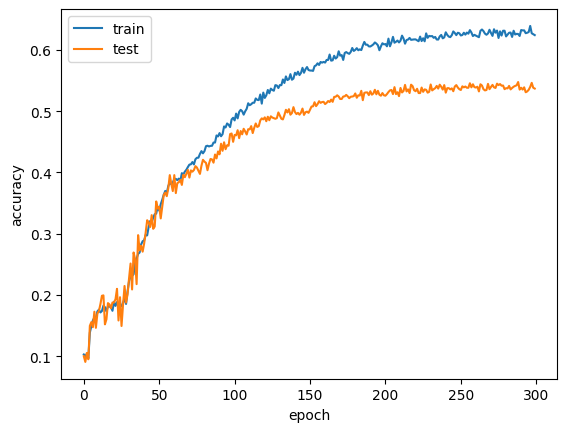

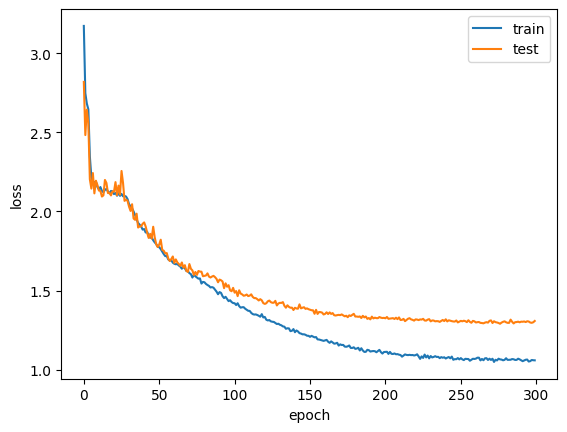

In [11]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [12]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet_CIFAR10-DVS_Hardtanh_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_exp1.csv')

In [13]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.102857,0.100000,3.173801,2.819572
1,0.100000,0.090667,2.748322,2.483323
2,0.104000,0.105333,2.682159,2.644608
3,0.097000,0.095000,2.646392,2.558907
4,0.138571,0.149667,2.348080,2.203695


In [14]:
print(df.to_string())

     train_acc  test_acc  train_loss  test_loss
0     0.102857  0.100000    3.173801   2.819572
1     0.100000  0.090667    2.748322   2.483323
2     0.104000  0.105333    2.682159   2.644608
3     0.097000  0.095000    2.646392   2.558907
4     0.138571  0.149667    2.348080   2.203695
5     0.149286  0.155667    2.215876   2.144856
6     0.158429  0.147333    2.191009   2.243087
7     0.163143  0.172667    2.183918   2.114496
8     0.162000  0.146333    2.188218   2.194478
9     0.173143  0.169667    2.155212   2.167830
10    0.176000  0.173667    2.139897   2.132593
11    0.171429  0.185000    2.154579   2.130097
12    0.173714  0.198667    2.130276   2.094497
13    0.182571  0.199333    2.121313   2.101958
14    0.180000  0.152000    2.136457   2.199367
15    0.173143  0.160333    2.142773   2.180036
16    0.181571  0.186667    2.126443   2.116360
17    0.181000  0.184667    2.114107   2.118058
18    0.180000  0.178333    2.129856   2.101440
19    0.174143  0.187667    2.128067   2